# Grover's Algorithm - An Attempt
## Yuanhao Ma

## Before Everything

In this notebook, I aim to reproduce some key contents from the paper ***Discrete Optimization: A Quantum Revolution?*** by ***Prof. Stefan Creemers*** and ***Dr. Luis Fernando Pérez*** using a numpy-based simulation. This is my first exposure to the idea that optimization methods can be fundamentally accelerated through quantum computing, a paradigm shift that offers a completely different perspective. If quantum computing becomes practically viable in the future, not only will hardware undergo a revolution, but there will also be a significant demand for new software. Moreover, lots of the classical algorithms may be challanged by more efficient quantum algorithms. This opens a vast research gap that needs to be explored in but not only in the OR Research community.

For now, we will primarily focus on reproducing the results from **Part 4: Grover’s Algorithm**

Grover’s algorithm is one of the most well-known quantum algorithms, making it an excellent starting point for understanding the fundamentals of quantum computing. By replicating this analysis, I seek to deeper understand the revolutionized opportunities in OR and identify open challenges.

## Grover's Algorithm

Grover's Algorithm is designed to find a target entry in an unsorted database. The quantum circuit for a two-qubit system is shown below (From *Discrete Optimization: A Quantum Revolution?*). The fundamental steps of the algorithm are as follows:
* **Initialization** (region1-2 in the circuit): Apply Hadamard gates to all qubits to create an equal superposition state.

* **Oracle Operator** (region2-3 in the circuit): Pass qubits through Oracle Operator to mark the target state by flipping its phase

* **Diffusion Operator** (region3-4 in the circuit): Amplify the probability amplitude of the target state through an inversion-about-the-mean operation. This step is repeated for n iterations to maximize the probability of measuring the correct result.

* **Measurement** (region4- in the circuit): Perform a quantum measurement to obtain the final result with high probability.


![Gover's Algorithm From *Discrete Optimization: A Quantum Revolution?*](<截屏2025-03-08 23.11.14.png>)
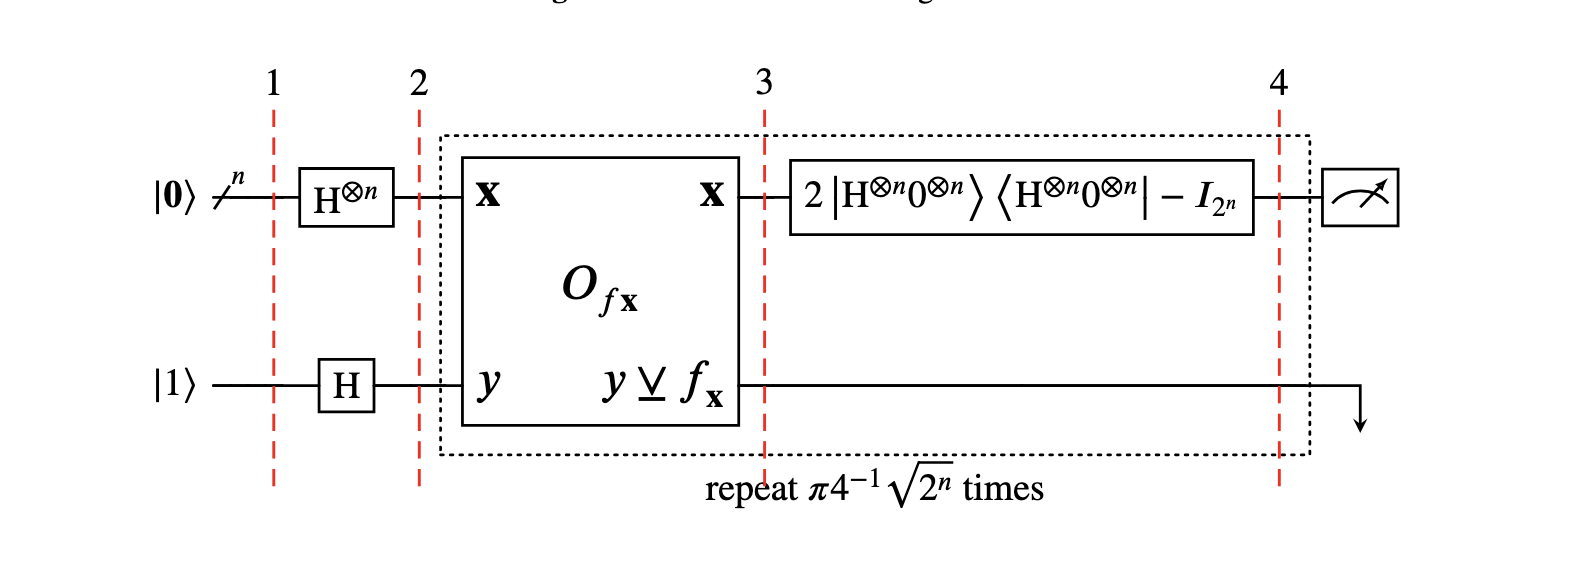

In [18]:
# import essential libriaries
import numpy as np
import matplotlib.pyplot as plt

**First, let's define how to use martix to represent n-qubit**

For a single qubit system ($n=1$), assume the basis state are $|0\rangle$ and $|1\rangle$, a general state representation is
$$
|\phi \rangle = \alpha_0 |0\rangle + \alpha_1 |1\rangle
$$
and the column vector could be

\begin{equation}
|\phi \rangle = \begin{bmatrix} \alpha_0 \\
                                 \alpha_1 
                \end{bmatrix}
\end{equation}

And for a 2-qubit system ($n=2$) there are $2^2$ possible states which are $|\phi \rangle = \alpha_0 |00\rangle + \alpha_1 |01\rangle +\alpha_2 |10\rangle + \alpha_3 |11\rangle$

And similarly a column vector representation could be

\begin{equation}
|\phi \rangle = \begin{bmatrix} \alpha_0 \\
                                 \alpha_1 \\
                                 \alpha_2 \\
                                 \alpha_3 
                \end{bmatrix}         
\end{equation}

The initialization of this column vector is very flexible; we only need to ensure that the sum of the squares of each entry is equal to 1 to meet the amplitude definition. We simply initialize the first state with an amplitude of 1, and all other states with 0 in the remaining part.

**Then, let's dive into the main algorithm.**

The first step is to define the Hadamard Gate Operator $H$. This is crucial because it initializes the qubits into an equal superposition state, distributing their probability amplitudes evenly across all possible states.

For example, a 1-qubit system column vector should meet $\alpha_0 ^ 2 + \alpha_1 ^ 2 = 1$ and $\alpha_0 ^ 2 = \alpha_1 ^ 2 = 0.5$ after Hadamard gate;


a 2-qubit system column vector should meet $\alpha_0 ^ 2 + \alpha_1 ^ 2 + \alpha_2 ^ 2 + \alpha_3 ^ 2= 1$ and $\alpha_0 ^ 2 = \alpha_1 ^ 2 = \alpha_2 ^ 2 = \alpha_3 ^ 2 = 0.25$ after Hadmard gate.

Since we want our function to be generalized for an n-qubit system, we will construct the n-dimensional Hadamard gate using the Kronecker product `(np.kron)`. The reason for using the Kronecker product is that the Hadamard transform on multiple qubits is simply the tensor product of single-qubit Hadamard gates. 

In [19]:
# Define the Hadmard Gate
def create_H_gate(n):
    base_H = np.array([[1, 1],
                       [1, -1]]) * (1/np.sqrt(2))
    H_n = base_H
    for _ in range(n-1):
        H_n = np.kron(H_n, base_H)
    
    return H_n

**Next let's define the Oracle Operator**. 

It serves for flipping the phase of the target state. Mathematically, an oracle for a search problem can be represented as a unitary matrix $U_{f(x)}$ that:

\begin{equation}
O|x\rangle=\{\begin{array}{ll}
-|x\rangle, & x \text { is the target state } \\
|x\rangle, & \text { else }
\end{array}
\end{equation}

In quantum computing literature, the oracle is often expressed in terms of a quantum Boolean function

\begin{equation}
    O_{f(x)}|xy\rangle =|x,y \underline{\vee} f(x)\rangle
\end{equation}

where $\underline{\vee}$ represent the XOR operation and $y$ is typically an auxiliary qubit. In some literatues, XOR also use the notation of $\oplus$. However, for simplicity, in our simulation, we adopt a simplified diagonal representation without explicitly using an auxiliary qubit.

For example, considering a 2-qubit system with the basis state order as $|00\rangle, |01\rangle, |10\rangle, |11\rangle$. We can create a $4*4$ identity matrix as our Oracle Operator and each column corresponds exactly to a computational basis state in the above order. To mark the target state, we simply change the diagonal entry corresponding to that state from $1$ to $-1$. For example, an Oracle operator for a 2-qubit system with target state $|10\rangle$ should be:

\begin{equation}
O = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation}

In [20]:
# Define the Oracle Gate
def oracle_fx(n, f):
    
    """
    n: Number of qubits
    f: A Boolean function identifying the target state

    """
    # possible number of states
    N = 2**n 
    O = np.eye(N)
    for i in range(N):
        # Flip the phase for the target state
        # e.g. if state |00> is the target state, then O[0,0] will become -1 in order to flip the pahse of the first quantum state
        # This is just an easy implementation of the Oracle Gate
        bin_x = format(i, f'0{n}b')
        if f(bin_x):
            O[i, i] = -1
    return O

**Then, let's delve into the Diffusion Operator:**

The diffusion operator $D$ serves to reflect the amplitudes of all basis states about their mean value. It is mathematically defined as:

$$
D = 2|s\rangle \langle s| - I
$$

where:
* $|s\rangle = H^{\otimes n}|0\rangle^{\otimes n}$ (with $\otimes$ denoting the tensor product)
* $I$ is the identity matrix of dimension $N\times N(N=2^n)$

To see why this operator works. Let's consider a simple classical analogy. Suppose we have a vector of amplitudes:$$ a = [1,1,-1,1]$$The mean amplitude is: $\bar{a} = (1 + 1 -1 + 1)/4 = 0.5$. The diffusion operation reflects each amplitude about this mean. For example:
* For the first item $1$, the reflected value is $2\times\bar{a} - a_{x} = 2 \times 0.5 - 1 = 0$ 

This results in the transformed vector is $[0, 0, 2, 0]$.

In the quantum setting, let $|\phi\rangle = \sum_{x=0}^{N-1}a_{x}|x\rangle$ represent a state with amplitudes $a_{x}$. The operator $D$ result to
$$
D|\phi\rangle = (2|s\rangle \langle s| - I)(|\phi\rangle) = 2|s\rangle \langle s|\phi\rangle - |\phi\rangle
$$

Since:
$$
|s\rangle = H^{\otimes n}|0\rangle^{\otimes n} = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}|x\rangle
$$
is the superposition with equal amplitude ($|s\rangle$ is a $N\times1$ matrix, $\langle s|$ is a $1\times N$ matrix). 

Then the inner product $\langle s|\phi\rangle$ is (the innner product of the amplitudes):
$$
\langle s| \phi \rangle = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}a_{x} = \sqrt{N}\bar{a}
$$

Then
$$
|s\rangle \langle s|\phi\rangle = \frac{1}{\sqrt{N}}\bar{a} |s\rangle = \sqrt{N}\bar{a}\frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}|x\rangle = \bar{a}\sum_{x=0}^{N-1}|x\rangle
$$

Then 
$$
2 |s\rangle \langle s| |\phi\rangle  - |\phi\rangle  = 2 \times \bar{a}\sum_{x=0}^{N-1}|x\rangle - \sum_{x=0}^{N-1}a_{x}|x\rangle = (2 \times \bar{a} - a_{x})\sum_{x=0}^{N-1}|x\rangle
$$
is just the same as the simple example we illustrated first.

In [82]:
# Strengthen the signal(Diffusion Operator)
def diffusion_strengthen(n):
    N = 2**n
    H = create_H_gate(n)
    s_ket = np.ones(N)/np.sqrt(N) # equal amplitude |x>
    D = 2*np.outer(s_ket, s_ket) - np.eye(N) # |x><x| - I
    return D

In [87]:
def Grover_Algo(n,f, corr_pos = -3,iterations = None):
    """
    n: Number of qubits
    f: A Boolean function identifying the target state
    corr_pos: the correct position of the target state, defaultly is -3 for target '101' in a 3-qubit system
    iteraations: how many iterations of diffusion operator you want, defaultly best iterations = int(np.round(np.pi / 4 * np.sqrt(2**n)))
    """
    # Start the simulation
    N = 2 ** n 
    H = create_H_gate(n)
    O = oracle_fx(n, f)
    D = diffusion_strengthen(n)

    res = []

    # initial state after a H gate for equal amplitude
    # ATTENTION!! :  The initialization is flexible, but we must ensure that the sum of the squares of the amplitudes equals 1
    psi = H @ np.array([1]+[0]*(N-1))
    
    # Save the squared amplitude at iteration 0
    res.append((np.abs(psi)**2)[corr_pos])
    
    # Best Grover iteration
    if iterations is None:
        iterations = int(np.round(np.pi / 4 * np.sqrt(2**n)))

    print("Inital probability distribution：", np.abs(psi)**2)

    # Grover Algorithm
    for i in range(iterations):
        psi = O @ psi 
        psi = D @ psi
        print(f"The {i+1}th iteration 'probability distribution'：{np.round(np.abs(psi)**2, 4)}")
        res.append((np.abs(psi)**2)[corr_pos])


    # Final result
    probabilities = np.abs(psi)**2
    result_state = np.argmax(probabilities)

    print(f"\n Final 'probability distribution'：{np.round(probabilities,4)}")
    print(f"Founded target state is：|{format(result_state, f'0{n}b')}⟩")
    
    return res

## Test a 3-qubit system

In [54]:
def get_corr_pos(n, target:str):
    """
    target: your target state in str format
    """
    basis_states = []
    for i in range(8):
        bin_x = format(i, f'0{n}b')
        basis_states.append(bin_x)
        
    return basis_states.index(target)
    

In [72]:
TARGET = '111'
# Here we define the f(x) that we want to evalutate
def f(x):
    if x == TARGET:
        return 1
    else:
        return 0

In [62]:
# Test with best iterations
n = 3
corr_pos = get_corr_pos(n, TARGET)  
res = Grover_Algo(n, f, corr_pos = corr_pos,iterations = None)

Inital probability distribution： [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
The 1th iteration 'probability distribution'：[0.0312 0.0312 0.0312 0.0312 0.0312 0.0312 0.0312 0.7812]
The 2th iteration 'probability distribution'：[0.0078 0.0078 0.0078 0.0078 0.0078 0.0078 0.0078 0.9453]

 Final 'probability distribution'：[0.0078 0.0078 0.0078 0.0078 0.0078 0.0078 0.0078 0.9453]
Founded target state is：|111⟩


We observe that after the 2nd iteration, the probability amplitude of the target state becomes dominant over other basis states, with only 
$1− 0.9453 =0.0547(5.47%)$ probability of measuring a non-target state. However, as shown in the results below, repeatedly applying the diffusion operator (e.g., $30$ iterations) reveals a critical property: the success probability oscillates periodically with the number of iterations. This is why Grover's algorithm specifies an optimal iteration count to avoid overshooting the peak probability.

In [63]:
# Test with 30 iterations
n = 3
corr_pos = get_corr_pos(n, TARGET)  
res = Grover_Algo(n, f, corr_pos = corr_pos,iterations = 30)

Inital probability distribution： [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
The 1th iteration 'probability distribution'：[0.0312 0.0312 0.0312 0.0312 0.0312 0.0312 0.0312 0.7812]
The 2th iteration 'probability distribution'：[0.0078 0.0078 0.0078 0.0078 0.0078 0.0078 0.0078 0.9453]
The 3th iteration 'probability distribution'：[0.0957 0.0957 0.0957 0.0957 0.0957 0.0957 0.0957 0.3301]
The 4th iteration 'probability distribution'：[0.1411 0.1411 0.1411 0.1411 0.1411 0.1411 0.1411 0.0122]
The 5th iteration 'probability distribution'：[0.0646 0.0646 0.0646 0.0646 0.0646 0.0646 0.0646 0.548 ]
The 6th iteration 'probability distribution'：[0.     0.     0.     0.     0.     0.     0.     0.9998]
The 7th iteration 'probability distribution'：[0.0604 0.0604 0.0604 0.0604 0.0604 0.0604 0.0604 0.577 ]
The 8th iteration 'probability distribution'：[0.1401 0.1401 0.1401 0.1401 0.1401 0.1401 0.1401 0.0195]
The 9th iteration 'probability distribution'：[0.0996 0.0996 0.0996 0.0996 0.0996 0.0996 0.099

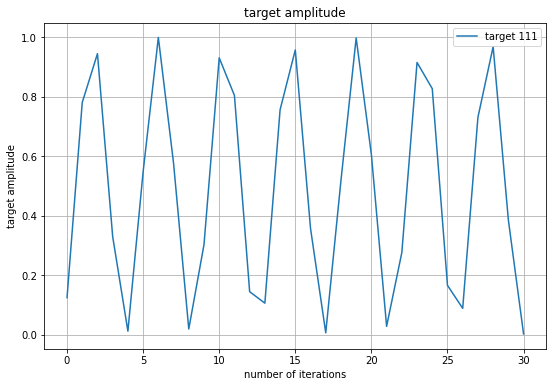

In [64]:
# Visulization
plt.figure(figsize=(9, 6))
plt.plot(res, label = f'target {TARGET}')
plt.legend()
plt.grid(True)
plt.xlabel('number of iterations')
plt.ylabel('target amplitude')
plt.title('target amplitude')
plt.show()

## Test a 2-qubit system

In [78]:
TARGET = '01'
# Here we define the f(x) that we want to evalutate
def f(x):
    if x == TARGET:
        return 1
    else:
        return 0

In [84]:
# Test with best iterations
n = 2
corr_pos = get_corr_pos(n, TARGET)  
res = Grover_Algo(n, f, corr_pos = corr_pos,iterations = None)

Inital probability distribution： [0.25 0.25 0.25 0.25]
The 1th iteration 'probability distribution'：[0. 1. 0. 0.]
The 2th iteration 'probability distribution'：[0.25 0.25 0.25 0.25]

 Final 'probability distribution'：[0.25 0.25 0.25 0.25]
Founded target state is：|00⟩


In this 1-qubit example, applying the theoretically "optimal" Grover iteration fails to maximize the amplitude of the target state. However, a single iteration achieves the highest possible amplitude ($100\%$), demonstrating the critical sensitivity of Grover’s algorithm to iteration counts in low-dimensional systems.

In [80]:
# Test with 30 iterations
n = 2
corr_pos = get_corr_pos(n, TARGET)  
res = Grover_Algo(n, f, corr_pos = corr_pos,iterations = 30)

Inital probability distribution： [0.25 0.25 0.25 0.25]
The 1th iteration 'probability distribution'：[0. 1. 0. 0.]
The 2th iteration 'probability distribution'：[0.25 0.25 0.25 0.25]
The 3th iteration 'probability distribution'：[0.25 0.25 0.25 0.25]
The 4th iteration 'probability distribution'：[0. 1. 0. 0.]
The 5th iteration 'probability distribution'：[0.25 0.25 0.25 0.25]
The 6th iteration 'probability distribution'：[0.25 0.25 0.25 0.25]
The 7th iteration 'probability distribution'：[0. 1. 0. 0.]
The 8th iteration 'probability distribution'：[0.25 0.25 0.25 0.25]
The 9th iteration 'probability distribution'：[0.25 0.25 0.25 0.25]
The 10th iteration 'probability distribution'：[0. 1. 0. 0.]
The 11th iteration 'probability distribution'：[0.25 0.25 0.25 0.25]
The 12th iteration 'probability distribution'：[0.25 0.25 0.25 0.25]
The 13th iteration 'probability distribution'：[0. 1. 0. 0.]
The 14th iteration 'probability distribution'：[0.25 0.25 0.25 0.25]
The 15th iteration 'probability distributi

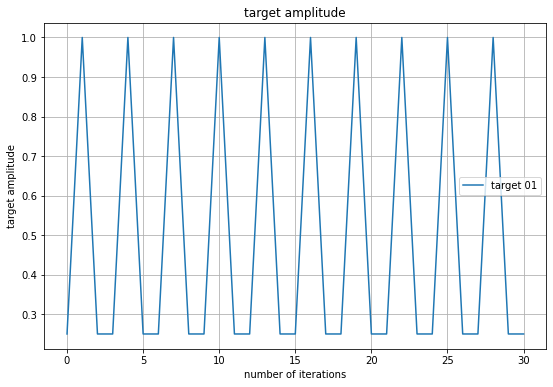

In [81]:
# Visulization
plt.figure(figsize=(9, 6))
plt.plot(res, label = f'target {TARGET}')
plt.legend()
plt.grid(True)
plt.xlabel('number of iterations')
plt.ylabel('target amplitude')
plt.title('target amplitude')
plt.show()

# Conlusion

In this project, we replicated Grover's algorithm using NumPy. We successfully reproduced the results, identifying the target state with the largest amplitude at the optimal number of iterations. Additionally, we observed the characteristic periodic oscillation of amplitudes, a hallmark of Grover's algorithm.

However, we also noted that while the algorithm significantly amplifies the probability of the target state, there remains a small but non-zero probability of measuring a non-target state. This suggests that multiple runs of the algorithm may be necessary to reliably identify the correct solution. Furthermore, more advanced quantum algorithms may exist to mitigate this limitation, which remains an open question for future research.

Beyond these findings, several directions for further exploration:

* Multiple Optimal Solutions: Many real-world optimization problems admit multiple optimal solutions. Investigating how Grover's algorithm (or its variants) can be adapted to such scenarios is a promising area of future study.
* Resource Constraints: As highlighted in the literature, modeling mixed-integer optimization problems with limited qubits presents a significant challenge. Developing efficient quantum encodings for such problems is another critical direction.
* Beyond Classical Simulation: Our implementation relies on classical matrix operations, which do not fully capture the behavior of quantum systems. Future work could focus on implementing and testing the algorithm on actual quantum hardware, such as IBM Qiskit or Rigetti Forest.